In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-07-14 10:11:33.521251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 10:11:33.521359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 10:11:33.655559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [4]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [5]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False  # No shuffling needed for testing
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [6]:
IMAGE_SIZE = [224, 224]

# Resnet 50

In [7]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

resnet50 = Model(inputs = resnet.input, outputs = prediction )
resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# COMPILING THE MODEL
resnet50.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [9]:
batch_size = 128

# resnet50 training

In [10]:
history = resnet50.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720952046.755591     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720952046.808718     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/94 ━━━━━━━━━━━━━━━━━━━━ 25s 812ms/step - accuracy: 0.5147 - loss: 38.4754

W0000 00:00:1720952097.213794     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.5909 - loss: 29.8623

W0000 00:00:1720952117.036890     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5929 - loss: 29.6562 - val_accuracy: 0.9540 - val_loss: 0.1608


W0000 00:00:1720952140.720213     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 571ms/step - accuracy: 0.9358 - loss: 0.2969 - val_accuracy: 0.9187 - val_loss: 0.4686
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step - accuracy: 0.9051 - loss: 1.4865 - val_accuracy: 0.9340 - val_loss: 0.4477
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9659 - loss: 0.1704 - val_accuracy: 0.9680 - val_loss: 0.1078
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 565ms/step - accuracy: 0.9739 - loss: 0.0727 - val_accuracy: 0.9740 - val_loss: 0.0711


In [11]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()


In [12]:
def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [14]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [15]:
result = resnet50.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.9682 - loss: 0.0942
test_loss, test accuracy [0.0799938514828682, 0.9753333330154419]


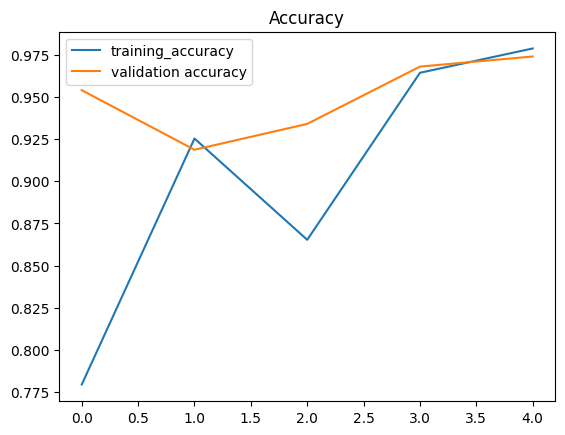

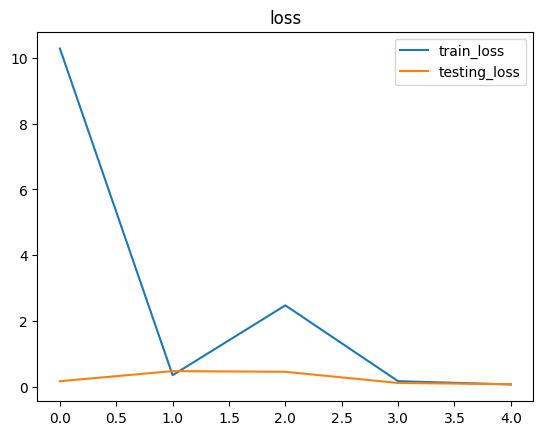

 1/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step

W0000 00:00:1720952381.596408     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 800ms/step


W0000 00:00:1720952390.391336     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[474   3  23]
 [  0 500   0]
 [ 11   0 489]]
Classification Report
              precision    recall  f1-score   support

         aca       0.98      0.95      0.96       500
           n       0.99      1.00      1.00       500
         scc       0.96      0.98      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [16]:
accuracy_curve(history)
loss_curve(history)
reports(resnet50,test_set)

# Model

In [17]:
import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras import layers, models, optimizers, losses

In [33]:
model_1 = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)



# model_1=models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(3, activation='softmax')  # 3 classes
# ])
model_1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_1.compile(optimizer=optimizers.Adam(learning_rate=0.001, decay=0.0001),
                  loss=losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

history = model_1.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 584ms/step - accuracy: 0.3762 - loss: 109.8727 - val_accuracy: 0.8080 - val_loss: 1.5203
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 559ms/step - accuracy: 0.7519 - loss: 0.9519 - val_accuracy: 0.7080 - val_loss: 0.5630
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.7181 - loss: 0.5844 - val_accuracy: 0.7033 - val_loss: 0.4124
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 543ms/step - accuracy: 0.6976 - loss: 0.5973 - val_accuracy: 0.7213 - val_loss: 0.3660
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 551ms/step - accuracy: 0.7529 - loss: 0.3664 - val_accuracy: 0.8447 - val_loss: 0.2636
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.8643 - loss: 0.2481 - val_accuracy: 0.8227 - val_loss: 0.2900
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 554ms/step - accuracy: 0.8448 - loss: 0.2665 - val_accuracy: 0.8613 - val_loss: 0.2145
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 557ms/step - accuracy: 0.8632 - loss: 0.2306 - val_ac

In [35]:
result = model_1.evaluate(test_set, batch_size=128)
print("test_loss, test accuracy", result)

# Generate classification reports
reports(model_1, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step - accuracy: 0.9263 - loss: 0.1573
test_loss, test accuracy [0.2408662885427475, 0.8759999871253967]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step
Confusion Matrix
[[474   4  22]
 [ 27 473   0]
 [133   0 367]]
Classification Report
              precision    recall  f1-score   support

         aca       0.75      0.95      0.84       500
           n       0.99      0.95      0.97       500
         scc       0.94      0.73      0.83       500

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.89      0.88      0.88      1500

